## Importing the goodies and defining some paths 


In [4]:
import torch
import torchvision
import torch.nn as nn                                                
import torch.nn.functional as F
import torch.optim as optim
torch.set_printoptions(linewidth = 120)
torch.set_grad_enabled(True)
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, TensorDataset
from torch.utils.data import DataLoader
from torch.utils.data.dataset import random_split
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image 
from IPython.display import clear_output
from torchvision.transforms import ToTensor
from scipy.ndimage.filters import gaussian_filter1d   ## smoother
from torch.optim.lr_scheduler import ReduceLROnPlateau
from imblearn.over_sampling import RandomOverSampler
import cv2
import time
from tqdm.notebook import tqdm
import Augmentor 
import torchvision.datasets as datasets
import os
from numpy import moveaxis
import pandas as pd

train_image_dir = "/content/drive/My Drive/kaggle/mind_the_bend/raw_images/"
test_image_dir = "/content/drive/My Drive/kaggle/mind_the_bend/test/"
ROOT = "/content/drive/My Drive/kaggle/mind_the_bend/"

# numpy image: H x W x C
# torch image: C X H X W

Using TensorFlow backend.


# Generate a CSV file containing the labels 
* The labels are the first three characters of the image name 



In [0]:
def  generate_csv(source_folder, save_path):
    
    final_stack = []
    for i in tqdm(os.listdir(source_folder)):   # i is the img_name btw
        filename = i
        label = i[:3]
        if label == "Cop":
            label = i[8:11]
        final_stack.append([filename, 400 - int(label)])
    final_stack = np.array(final_stack)

    np.savetxt(save_path , final_stack, delimiter=",", fmt = "%s")
    print("saved --", save_path)

In [0]:
generate_csv(train_image_dir, ROOT + "train_labels.csv")
generate_csv(test_image_dir, ROOT + "test_labels.csv")

## Balancing training data with the `RandomOverSampler()`

In [0]:
df = pd.read_csv("/content/drive/My Drive/kaggle/mind_the_bend/train_labels.csv")
df_test = pd.read_csv("/content/drive/My Drive/kaggle/mind_the_bend/test_labels.csv")

In [0]:
X = df[df.columns[0]].values.reshape(-1,1)
y = df[df.columns[1]].values
ros = RandomOverSampler(random_state=0)
x_resampled, y_resampled = ros.fit_resample(X, y)

In [0]:
x_vals  = np.array(x_resampled.reshape(1,-1)[0])
y_vals = np.array(y_resampled)

In [0]:
new_list = []
for i in range(len(x_vals)):
    new_list.append([  x_vals[i], y_vals[i] ])
new_df = pd.DataFrame(new_list)


In [69]:
new_df[new_df.columns[1]].value_counts()

 223    115
-87     115
 137    115
 169    115
 10     115
       ... 
-75     115
 85     115
-107    115
 117    115
 0      115
Name: 1, Length: 297, dtype: int64

In [0]:
balanced_labels = new_df.values
np.savetxt(ROOT + 'balanced_labels.csv', balanced_labels, delimiter=',', fmt = "%s")

## Comparing the distributions of balance and unbalanced data 

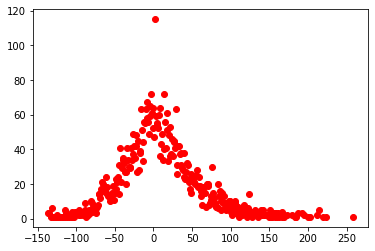

In [71]:
plt.plot(df[df.columns[1]].value_counts(), "ro")

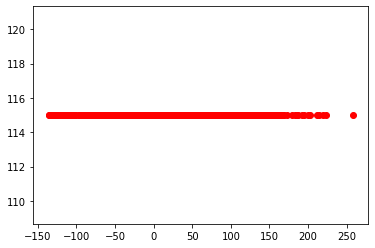

In [72]:
plt.plot(new_df[new_df.columns[1]].value_counts(), "ro")

In [0]:
def img_to_arr(im_path):

    img = Image.open(im_path)
    x = np.array(img)

    return x

## Custom DataLoader class whic would be compatible with image folders and CSV files 


In [0]:
class MyDataset(Dataset):
    '''
    Build your own dataset
    '''
    def __init__(self, image_folder_path, csv_file_path , transform = None):

        self.transform = transform

        print(csv_file_path)

        self.labels = pd.read_csv(csv_file_path, header= None)
        self.label = []
        self.img = []
        self.c = 0

        for i in tqdm(self.labels.values):

            filename = i[0]
            full_path = image_folder_path + filename
            label_y = i[1]

            image_np_array = img_to_arr(full_path)
            self.label.append(label_y)
            self.img.append(image_np_array)

        self.label = np.array(self.label)
        self.img = np.array(self.img)

    def __getitem__(self, item):
        label, img = self.label[item], self.img[item]
        if self.transform is not None:
            img = self.transform(img)

        return img, torch.tensor([label])

    def __len__(self):
        return len(self.label)

In [0]:
!cp  /content/drive/"My Drive"/kaggle/mind_the_bend/raw_images.tar.gz /content/ 

In [0]:
!rm -rf raw_images
!mkdir raw_images
!tar -xf /content/raw_images.tar.gz -C /content/raw_images

In [ ]:
train_set = MyDataset("/content/raw_images/", ROOT + "balanced_labels.csv", 
              transform =transforms.Compose([          
                                                transforms.ToPILImage(),
                                                torchvision.transforms.RandomAffine(degrees = 5, translate= (0.09, 0.09), scale=None, shear=None, resample=False, fillcolor=0),
                                                ToTensor()
                                           ])
              )
test_set = MyDataset(test_image_dir, ROOT + "test_labels.csv", 
              transform =transforms.Compose([  
                                             
                                            ToTensor()
                                           ])
              )

## Loading up the training data in a batches

In [0]:
train_batch_size = 800
test_batch_size = 2
train_loader = DataLoader(train_set, batch_size=train_batch_size, shuffle = True, num_workers = 4)
test_loader = DataLoader(test_set, batch_size =test_batch_size)

## Viewing some samples from training data 

torch.Size([3, 25, 80])


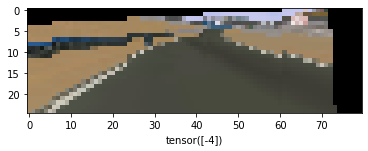

torch.Size([3, 25, 80])


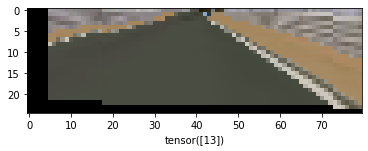

torch.Size([3, 25, 80])


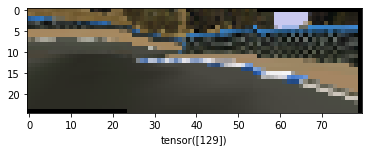

torch.Size([3, 25, 80])


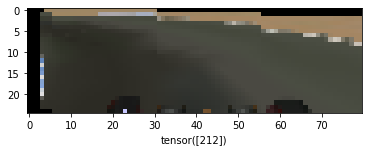

torch.Size([3, 25, 80])


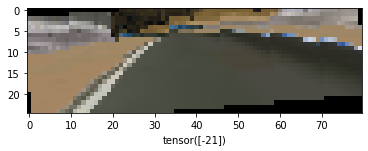

In [97]:
sample = next(iter(train_loader))
image_batch, labels = sample
for i in range (5):


    print(image_batch[i].size())
    image_np = image_batch[i].squeeze(0).squeeze(0).numpy()
    image_mvaxis = moveaxis(image_np, 0,2)
    plt.imshow(image_mvaxis)
    plt.xlabel(str(labels[i]))
    plt.show()

In [0]:
def vis_loss_multi(loss_arr,val_arr):
    
    ysmoothed = gaussian_filter1d(loss_arr, sigma=7)
    plt.plot( ysmoothed, label = "training loss")
    ysmoothed2 = gaussian_filter1d(val_arr, sigma=18)
    plt.plot(ysmoothed2, label = "validation loss")
    plt.show()

def vis_loss_multi_colors(loss_arr,val_arr):
    
    ysmoothed = gaussian_filter1d(loss_arr, sigma=3)
    plt.plot( ysmoothed, "c", label = "training")
    ysmoothed2 = gaussian_filter1d(val_arr, sigma=7)
    plt.plot(ysmoothed2, "g", label = "validation")
    plt.grid(True)
    plt.ylabel("Loss", fontsize = 15)                                       
    plt.xlabel("batches", fontsize=15)
    plt.legend()
    plt.show()     

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def show_lr(learning_rates):
    plt.plot(learning_rates, label = "learning rate")
    plt.ylabel("Learning rate", fontsize = 15)
    plt.grid(True)
    plt.legend()
    plt.show()

In [99]:
print(len(train_loader), "batches ")
print(len(test_loader), " batches ")

43 batches 
47  batches 


In [0]:

def train_step(x, y, model, optimizer):
        optimizer.zero_grad()
        pred = model(x)
        y = y.float()
        loss = F.mse_loss(pred,y)
        loss.backward()
        optimizer.step()
        return loss.item()

def train_model(epochs, cellnet, optimizer, train_loader, val_loader):
    start = time.process_time()
    losses = []
    val_losses = []

    learning_rates = []

    for m in range (epochs):
        clear_output(wait = True)
        vis_loss_multi_colors(losses, val_losses)
        show_lr(learning_rates)
        print ("epoch ", m+1, " out of ", epochs )
        
        with torch.no_grad():
            cellnet.eval()

            for x_val, y_val in tqdm(val_loader, desc = "running on test set --"):
                yhat =cellnet(x_val)  # pred 
                val_loss = F.mse_loss(yhat, y_val)
                val_losses.append(val_loss.item())  ## metrics 
        cellnet.train()
        
        for batch in tqdm(train_loader, desc = " Training batches : "):


                (x_batch, y_batch) = batch
                loss = train_step(x_batch, y_batch, cellnet, optimizer)
                losses.append(loss)
        scheduler.step(1.)   ## lr decay caller 
        learning_rates.append(get_lr(optimizer))

    clear_output(wait = True)

    vis_loss_multi_colors(losses, val_losses)
    vis_loss_multi_colors(losses[-100:], val_losses[-100:])

    print ("Time elapsed = ", time.process_time() - start, " seconds" )
    return losses, val_losses


In [121]:

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 10, 5)
        self.pool = nn.MaxPool2d(3, 3)
        
        self.dropout = nn.Dropout(p=0.5)
        self.conv2 = nn.Conv2d(10, 15, 5)
        
        self.fc1 = nn.Linear(105,70)
        self.fc2 = nn.Linear(70, 50)
        self.fc3 = nn.Linear(50, 1)

    def forward(self, x):
        x = (self.pool(F.relu(self.conv1(x))))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)

        return x

drunk_driver = Net()
print(drunk_driver)

optimizer = optim.Adam(drunk_driver.parameters(), lr = 0.02) 

scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.6, patience=7, verbose=False, threshold=0.0001, threshold_mode='rel', cooldown=0, min_lr=0, eps=1e-08)


Net(
  (conv1): Conv2d(3, 10, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.5, inplace=False)
  (conv2): Conv2d(10, 15, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=105, out_features=70, bias=True)
  (fc2): Linear(in_features=70, out_features=50, bias=True)
  (fc3): Linear(in_features=50, out_features=1, bias=True)
)


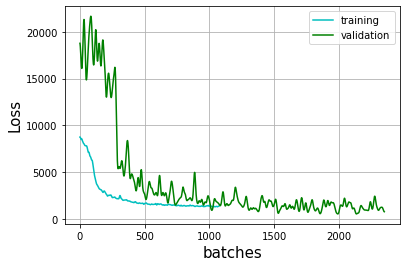

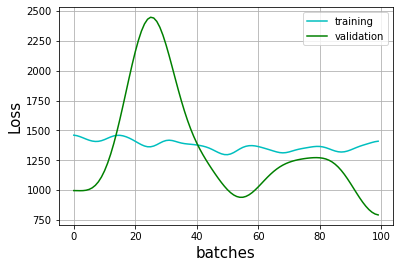

Time elapsed =  430.9288697190002  seconds


In [122]:
loss_1, val_loss_1 = train_model(25, drunk_driver, optimizer,   train_loader, test_loader)

In [0]:
torch.save(drunk_driver.state_dict(), ROOT + "drunk_driver.pt")

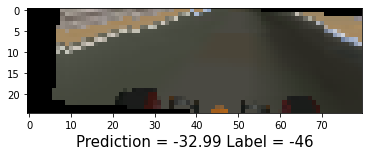

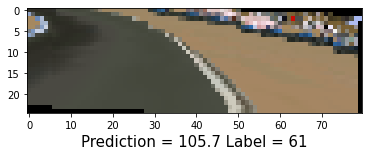

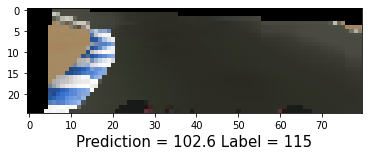

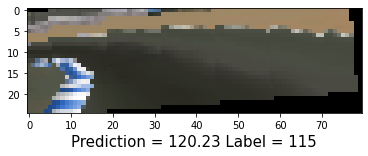

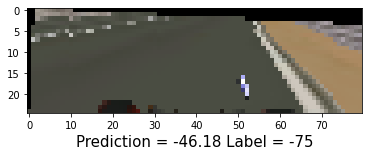

In [142]:
sample = next(iter(train_loader))

image_batch, labels = sample

for i in range (5):
    res = drunk_driver(image_batch[i].unsqueeze(0)).item()
    image_np = image_batch[i].squeeze(0).squeeze(0).numpy()
    image_mvaxis = moveaxis(image_np, 0,2)
    plt.imshow(image_mvaxis)

    x = "Prediction = " +  str(round(res,2)) + " Label = " + str(labels[i].item())
    plt.xlabel(x, fontsize= 15)
    plt.show()
    